# Case study Chile 2017

This notebook reproduces the plots and the analysis as displayed in the WildFire paper by Lüthi et al.

This notebook is pre-calculated. In order to do the calculations yourself please downlaod and install CLIMADA which is available at https://github.com/CLIMADA-project/climada_python

Please refer to details on installation and model set-up to
https://climada-python.readthedocs.io/en/v0.1.0/install.html

# Input data:

Data on past wildfire activity can be downloaded at https://firms.modaps.eosdis.nasa.gov/download/
Please select data for Chile and January 2017 as time horizon.
Data on exposure and vulnerability is available directly through CLIMADA (or via APIs)

# Import climada.WildFire() and required libraries

In [1]:
import os
import sys
sys.path.append('/Users/sam/Documents/GitHub/climada_python')
from climada.hazard.wildfire import WildFire
from climada.hazard import Centroids

from climada.entity.exposures.base import Exposures
from climada.entity.exposures.litpop import LitPop
from climada.entity.impact_funcs.wildfire import ImpfWildfire
from climada.entity.impact_funcs import ImpactFuncSet

from climada.engine import Impact

from climada.util.constants import ONE_LAT_KM
from climada.util.dates_times import date_to_str
from climada.util.scalebar_plot import scale_bar
import climada.util.plot as u_plot

from matplotlib import colors
import numpy as np
import pandas as pd
import geopandas as gp
import pickle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from copy import copy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LogNorm

# Set up hazard (wildfire)

We load the FIRMS data as downloaded, and map it onto a regular grid of centroids.

In [2]:
""" Data Paths """
DATA_path = "/Users/sam/OneDrive - ETH Zurich/WCR/Projects/Bush_fire/Data/"
DIR_MODIS = os.path.join(DATA_path, "Australia_2020/AUS2020_fire_archive_M6_174881.csv")


""" Define region """
lat_max = -28.
lat_min = -40.
lon_max = 153.
lon_min = 144.

""" Hazard calcs """
# load data
firms = pd.read_csv(DIR_MODIS)
set_zoom = [lon_min, lat_min, lon_max, lat_max]
res = 4./ONE_LAT_KM # resolution is set to 4 km

# set up centroid grid
centr_zoom = Centroids()
centr_zoom.set_raster_from_pnt_bounds(set_zoom, res)

# calculate hazard
wf_main = WildFire()
wf_main.set_hist_fire_FIRMS(firms,centroids=centr_zoom)
wf_main.combine_fires()

## Set up exposure (LitPop)

We load LitPop and cut it to the defined region

In [5]:
""" Load exposure """
aus = LitPop()
aus.set_country('AUS', res_arcsec=120, reference_year=2017) # this might take a minute while

# cut to defined region
aus.gdf = aus.gdf[aus.gdf['latitude']>lat_min]
aus.gdf = aus.gdf[aus.gdf['latitude']<lat_max]
aus.gdf = aus.gdf[aus.gdf['longitude']>lon_min]
aus.gdf = aus.gdf[aus.gdf['longitude']<lon_max]
aus.set_geometry_points()
aus.check()

/Users/sam/Documents/GitHub/climada_python/climada/entity/exposures/base.py:219: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']
/Users/sam/Documents/GitHub/climada_python/climada/entity/exposures/base.py:752: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  exp.gdf = GeoDataFrame(
/Users/sam/opt/anaconda3/envs/climada_env/lib/python3.8/site-packages/geopandas/geodataframe.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)
/Users/sam/Documents/GitHub/climada_python/climada/entity/exposures/base.py:188: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported i

## Set up vulnerability and calculate damages

In [6]:
# set up impact function
if_wf = ImpfWildfire()
if_wf.set_default_FIRMS(i_half=409.5) # as calibrated for 4 km resolution
if_wf.check()
impf_ = ImpactFuncSet()
impf_.append(if_wf)

# Impact
imp = Impact()
imp.calc(aus, impf_, wf_main, save_mat=True)

## Plot results

In [7]:
# plotting functions
def plot_haz_hexbin(haz, palette, **kwargs):
    value_haz = haz.intensity.toarray() #np.array of intensity
    geo_coord_haz = np.stack([haz.centroids.lat, haz.centroids.lon], axis=1)
    var_name_haz = 'Intensity (K)'
    title = ''
    BUFFER = 0.01
    ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                             squeeze=True, sharex=False, sharey=True)
    ax = u_plot.geo_bin_from_array(value_haz, geo_coord_haz, var_name_haz, title,
                              pop_name=True, buffer=BUFFER, extend='neither',
                              proj=ccrs.PlateCarree(), axes=None, cmap=palette,
                              gridsize=100, vmin=200, vmax=500)
    scale_bar(ax, (0.80, 0.10), 50)
    
def plot_exp_hexbin(exp, palette, **kwargs):

    value_exp = exp.gdf.value.values #np.array exposure values
    geo_coord_exp = np.stack([exp.gdf.latitude.values, exp.gdf.longitude.values], axis=1)
    var_name_exp = 'Value (USD)'
    title = ''
    BUFFER = 0.01
    ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                             squeeze=True, sharex=False, sharey=True)
    ax = u_plot.geo_bin_from_array(value_exp, geo_coord_exp, var_name_exp, title,
                              pop_name=True, buffer=BUFFER, extend='neither',
                              proj=ccrs.PlateCarree(), axes=None, cmap=palette,
                              gridsize=100, norm=LogNorm(vmin=1, vmax=10**11))
    scale_bar(ax, (0.80, 0.10), 50)
    
def plot_imp_hexbin(imp, exp, palette, **kwargs):

    value_imp = imp.imp_mat.toarray()
    geo_coord_imp = np.stack([exp.gdf.latitude.values, exp.gdf.longitude.values], axis=1)
    var_name_imp = 'Value (USD)'
    title = ''
    BUFFER = 0.01
    ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                             squeeze=True, sharex=False, sharey=True)
    ax = u_plot.geo_bin_from_array(value_imp, geo_coord_imp, var_name_imp, title,
                              pop_name=True, buffer=BUFFER, extend='neither',
                              proj=ccrs.PlateCarree(), axes=None, gridsize=100,
                              cmap=palette, norm=LogNorm(vmin=10, vmax=10**8))
    scale_bar(ax, (0.80, 0.10), 50)
        

# define color maps
pal_exp = copy(plt.get_cmap('BuPu'))
pal_haz = copy(plt.get_cmap('YlOrRd'))
pal_haz.set_under('white', 1.0) 
pal_imp = copy(plt.get_cmap('magma_r'))
pal_imp.set_under('white', 1.0) 


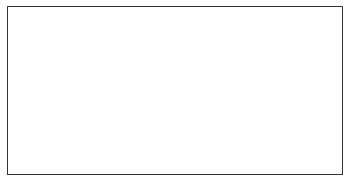

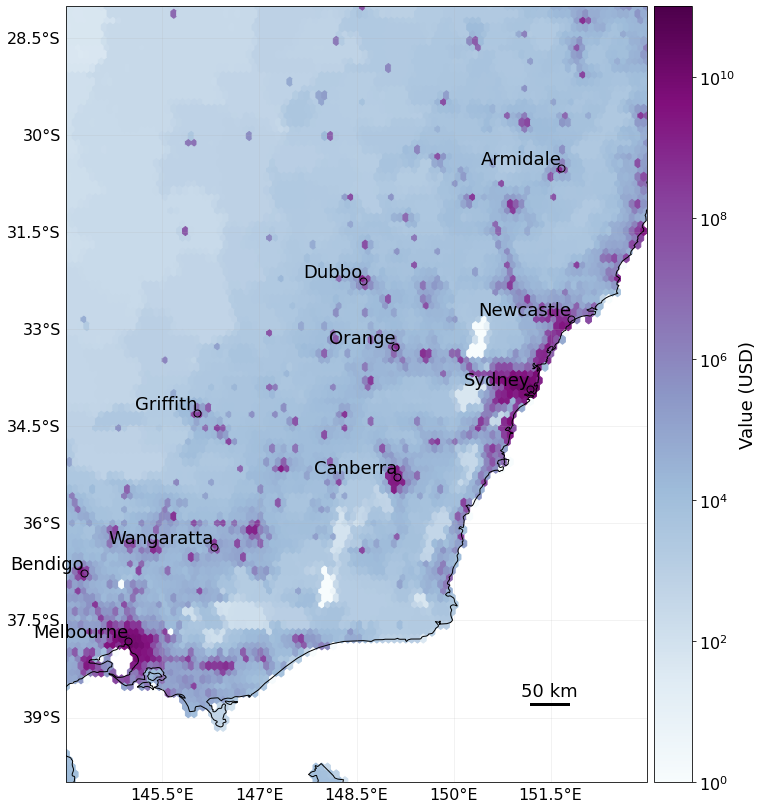

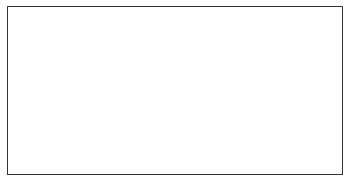

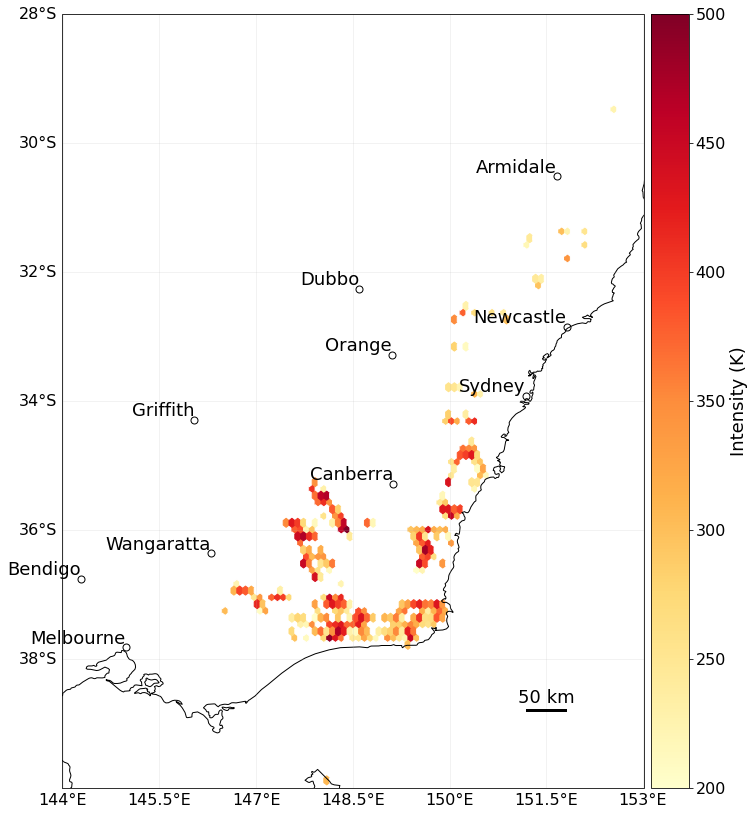

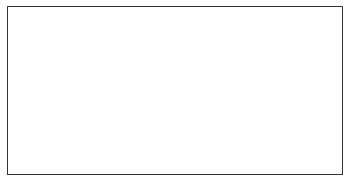

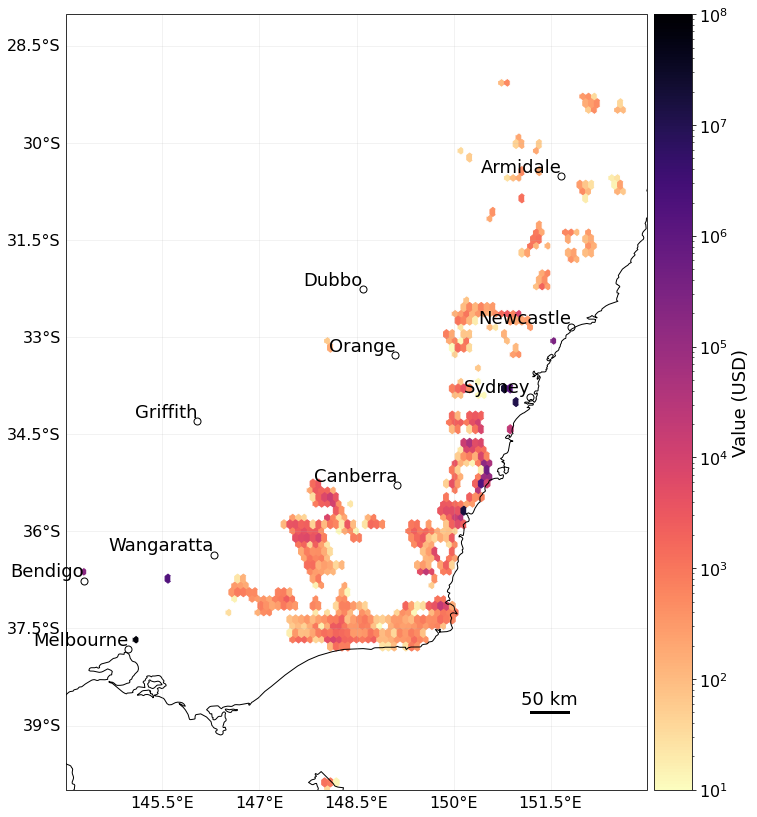

In [9]:
# make plots
plot_exp_hexbin(aus, pal_exp)
plot_haz_hexbin(wf_main, pal_haz)
plot_imp_hexbin(imp, aus, pal_imp)